![RASA](http://i.imgur.com/aImJD4o.png)


## Instructions
The point of this exercise is to give you the chance to show us what you know, can do, and how well you communicate what you find out. 

For this exercise to be useful we of course can't have solutions on the internet.
This should go without saying but please don't distribute these questions in any form.

When you feel you're ready please email your solution, with cell output, to the email address that sent this.
If you like you can also include pdf/html exports in addition to the `.ipynb` file itself. **In your email you must include a statement that this is your original work and was completed only by you.**

The exercise uses python, and the `numpy` and `matplotlib` libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Part 1: warm-up exercise.

The function below draws a sample from an unnormalised discrete distribution.
1. Explain how it works
2. Write a vectorised version, which takes the number of samples to generate as an extra parameter, and returns a numpy array of samples

In [2]:
def sample_discrete(b):
    r = np.sum(b)*np.random.random()
    a = b[0].copy()
    i = 0
    while a < r:
        i += 1
        a += b[i]
    return i


In [3]:
def sample_vectoraized_discrete(b, n_samples):
    # sample intervals
    r = np.sum(b)*np.random.random([n_samples, 1])
    # compute cumulative probability to compare with the sampled intervals
    a = np.cumsum(b)
    # return the index of the biggest cumulative value smaller than the sampled value.
    # Note that this operation is done sample wise.
    return np.sum(a < r, axis=1)

Here's an example of how it works, with probabilities `b`

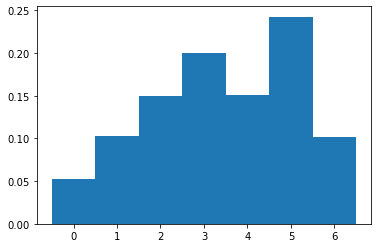

In [4]:
b = np.array([0.1,0.2,0.3,0.4,0.3,0.5,0.2,0.03])
n_samples = 10000
bins = np.arange(b.size) - 0.5

np.random.seed(0)
samples = np.array([sample_discrete(b) for _ in range(n_samples)])

# reset the seed to obtain equal sample for comparison
np.random.seed(0)
vectorized_samples = sample_vectoraized_discrete(b, n_samples)

# make sure that code is correct
assert np.all(samples == vectorized_samples)

plt.hist(samples,bins, density=True)
plt.show()


# Explanation 1

Drawing samples from any probability distribution $P(X)$ is an important task since each samples can be used to
approximate expectations of functions depending on $P(X)$.

For any discrete distribution, given a probability mass function $p(x) = P(X=x)$; it's cumulative distribution function is:

$$F(x_j) = \sum_{i \leq j} p(x_i)$$

Now assume that $p(x)$ is a proper (normalized) probability mass function, then an easy way to sample from $p(x)$ is to:

 - lay out each possible outcome on a stick of length 1
 - sample a value $u$ from an uniform distribution
 - identify in which interval of the cumulative distribution function $u$ fall into and select and the associated $x_j$

More formally, we can partition $F(x)$ in intervals:

- $$ [\Big(0, F(x_1) \Big), \Big(F(x_1), F(x_2) \Big), ..., \Big(F(x_k), 1 \Big)]$$
- Drawn $u \sim Uniform(0, 1)$
- Check in where interval $F(x_{i-1}) \leq u \leq F(x_i)$
- Sample $F(x_i)$

Such method can be easily extended to unnormalised discrete distribution, where instead to sampling $u$ from Uniform(0,1) we sample
$u$ from $(0, F(X))$. Thus, we have:
```python
r = np.sum(b) * np.random().random()
```
Instead of:
```python
r = np.random().random()
```





# Topic Modeling

This section is about unsupervised learning with text data.
We'll be using a relatively small dataset, consisting of 3430 documents and a vocabulary of 6906 words drawn from the daily kos blog around 2004. 

You can download the data [here](https://s3-eu-west-1.amazonaws.com/lastmilecoding/exercise.tar.gz).


## Bayesian mixture model

We're going to model the documents as bags of words, with a bayesian mixture model.
The documents are modeled using $K$ topics.
The assignment of a document to a topic is modeled by the latent variable $z_d$.

The topics are drawn from a categorical distribution with parameters $\theta$, where $\theta$ is drawn from a Dirichlet prior with parameter $\alpha$.

Each topic specifies a categorical distribution over words. The prior on each of these distributions is a Dirichlet with parameter $\gamma$. 


The figure below shows this in a graphical model.


![Graphical Model](http://i.imgur.com/AAGnKZ7.png)

For simplicity, let's denote with $y_n$ the observations (i.e. the documents we see in the corpus).
The conditional likelihood is:

$$p(y_n|z_n \negmedspace = \negmedspace k,\beta) = p(y_n|\beta_k) = p(y_n|\beta_{z_n})$$

And we have a prior:

$$p(\beta_k)$$

And a (latent) categorical assignment probability:

$$p(z_n \negmedspace= \negmedspace k|\theta) = \theta_k$$

which has a Dirichlet prior:

$$p(\theta|\alpha) = Dir(\alpha)$$

Which gives our latent posterior:

$$ p(z_n\negmedspace=\negmedspace k|y_n,\theta,\beta) \quad \propto p(z_n\negmedspace =\negmedspace k|\theta)p(y_n|z_n \negmedspace = \negmedspace k,\beta) \quad \propto \theta_k p(y_n|\beta_{z_n}) $$


### Gibbs Sampling
We will explore this model by drawing from the posterior using MCMC, specifically Gibbs sampling.

We will alternately sample the three types of variables, & iterate this procedure multiple times.

First we'll sample the component parameters:

$$p(\beta_k|y,z) \quad \propto p(\beta_k) \prod_{n:z_n=k} p(y_n|\beta_k) $$

Then the latent allocations of documents to topics:
$$ p(z_n \negmedspace= \negmedspace k|y_n,\theta,\beta) \quad \propto \theta_k p(y_n|\beta_{z_n})$$

and then the mixing proportions:

$$p(\theta|z,\alpha) = p(\theta|\alpha)p(z|\theta) = \mathrm{Dir}\left(\frac{c_k+\alpha_k}{\sum_j c_j + \alpha_j}\right)$$

where $c_k$ are the counts for mixture component $k$.

### The Collapsed Gibbs Sampler

We marginalise over $\theta$. (You do not need to derive this result).
N.B. the notation $c_{-n}$ indicates all indices _except_ $n$. 

$$p(z_n \negmedspace= \negmedspace k|z_{-n},\alpha) = \frac{\alpha + c_{-n,k}}{\sum_j \alpha + c_{-n,j}}$$

which gives the _collapsed_ gibbs sampler for the latent assignments:

$$p(z_n \negmedspace= \negmedspace k|y_n,z_{-n},\beta,\alpha) \propto p(y_n|\beta_k) \frac{\alpha + c_{-n,k}}{\sum_j \alpha + c_{-n,j}}$$

### Code

The documents have been split into two corpora, `A` and `B`.

The array `words` is a list of all the words in both corpora.
The matrices `A` and `B` are the train and test corpora, respectively. 
Each has 3 columns, there is one row for each unique word in each document.

The first column is the document index, second is the word index (corresponding to `words`), and the third is the number of times that word appears in the document. 

In [5]:
A = np.load('data/mat_A.npy')
B = np.load('data/mat_B.npy')
words = np.load('data/words.npy')

W = np.max(np.hstack((A[:,1],B[:,1]))) + 1   # number of unique words
D = np.max(A[:,0]) + 1   # number of documents in A
K = 20 # number of mixture components we will use

alpha = 10  # parameter of the Dirichlet over mixture components
gamma = 0.1 # parameter of the Dirichlet over words

The function below defines the following matrices:
 * `sd` : the mixture component assignment of each document
 * `swk` : K multinomial distributions over W unique words
 * `sk_docs` : the number of documents assigned to each mixture component
 * `sk_words` : the number of words assigned to mix component `k` accross all docs
 
These are initialised by assigning each document to a mixture component at random.

In [6]:
def init():
    sd = np.floor(K*np.random.random((D,1))).astype(int)   
    swk = np.zeros((W,K))              
    sk_docs = np.zeros((K,1)) 

    for d in np.arange(D): 
        w = A[A[:,0]==d,1]      # unique words in doc d
        c = A[A[:,0]==d,2]      # counts
        k = sd[d]               # doc d is in mixture k
        swk[w,k] = swk[w,k] + c # num times word w is assigned to mixture component k
        sk_docs[k] = sk_docs[k] + 1

    sk_words = np.sum(swk,axis=0).T
    return sd, swk, sk_docs, sk_words

The following code starts from this initial state & then performs a number of gibbs sampling sweeps. 
We will use the collapsed Gibbs sampler, which uses the trick of excluding the current document's counts before calculating the posterior and resampling.


In [7]:
sd, swk, sk_docs, sk_words = init()
# This makes a number of Gibbs sampling sweeps through all docs and words
num_sweeps = 10
for i_sweep in np.arange(num_sweeps): 
    print("gibbs sweep : {0}".format(i_sweep))
    for d in np.arange(D):
        w = A[A[:,0]==d,1]      # unique words in doc d
        c = A[A[:,0]==d,2]      # counts

        # remove doc d's contributions from count tables
        swk[w,sd[d]] = swk[w,sd[d]] - c 
        sk_docs[sd[d]] = sk_docs[sd[d]] - 1 
        sk_words[sd[d]] = sk_words[sd[d]] - np.sum(c) 
        
        # log probability of doc d under each mixture component
        lb = np.zeros(K)    
        for k in np.arange(K):
            ll = np.dot(c,( np.log(swk[w,k]+gamma) - np.log(sk_words[k] + gamma*W) ))
            lb[k] = np.log(sk_docs[k] + alpha) + ll

        # assign doc d to a new component
        b = np.exp(lb-np.max(lb))  
        kk = sample_discrete(b)  

        # add back doc d's contributions from count tables
        swk[w,kk] = swk[w,kk] + c 
        sk_docs[kk] = sk_docs[kk] + 1 
        sk_words[kk] = sk_words[kk] + np.sum(c)
        sd[d] = kk

gibbs sweep : 0
gibbs sweep : 1
gibbs sweep : 2
gibbs sweep : 3
gibbs sweep : 4
gibbs sweep : 5
gibbs sweep : 6
gibbs sweep : 7
gibbs sweep : 8
gibbs sweep : 9


## Part 2.1

The code above is divided in:
- a first part that define the model hyper-parameters. The most important are ``K, alpha`` and ``gamma``.
- we randomly assign each document to a possible topic (```sd = np.floor(K*np.random.random((D,1))).astype(int)```)
- based on the document assignment, it is possible to randomly initialize the counting matrixes


Once all the needed data structure are randomly initialized, it is time to perform multiple steps of gibbs sampling to approximate the posterior distribution.
Specifically, for each document ``d`` in my training set:
- we exclude ``d`` from the current counting
- we compute a new document-topic assignment based on the updated counting $$p(z_n \negmedspace= \negmedspace k|y_n,z_{-n},\beta,\alpha) \propto p(y_n|\beta_k) \frac{\alpha + c_{-n,k}}{\sum_j \alpha + c_{-n,j}}$$
- we assign document ``d`` to a new topic based on the (log) probability previously computed
- update the counting of our model according to the updated topic assignment


I'm not really a fan of such model:
- first of all, I would suggest a different parameter initialization. ``alpha = 10`` assume that a document might be associated to random topics (I have not tested it with different values, but usually model like LDA use an ``alpha < 1``).
Topic models are usually adopted as an unsupervised method to do document classification/clustering over it's topic.
Thus, we would like to have document associated to a relevant topic.
``gamma = 0.1`` seems a common prior for topic-word distribution.
- As LDA, even this mixture model does not consider the words' order, thus has a limited understanding of the semantic of each document. A bi-gram model could highly prevent such issue.
- Bayesian mixture models are highly sensitive to the noise present in each document. Thus, it require careful preprocessing such as: stopword removal, stemming (seems that you haven't use stemming nor language check).
- On the one had, LDA is not easily applicable to social media content such as twitter, where short documents (tweets) does not present significant word co-occurence. On the other hand, this simpler model might overcome the sparisity issue associated to short text since the topic distribution is sampled once at corpus level.


In [8]:
def log_ll(B, d, swk, sk_docs, sk_words, alpha, gamma, W, K):
    w = B[B[:, 0] == d + 2000, 1]
    c = B[B[:, 0] == d + 2000, 2]

    t = np.zeros([K, W])
    for k in np.arange(K):
        th = (sk_docs[k] + alpha) / np.sum(sk_docs + alpha)
        ph = (swk[:, k] + gamma) / (sk_words[k] + gamma * W)
        t[k] = th * ph

    p = c * np.log(t[:, w].sum(0))
    return p.sum(0)

print(log_ll(B, 0, swk, sk_docs, sk_words, alpha, gamma, W, K))

-3684.9094661054687


## Part 2.2

The log-probability describe how probable is that the words in a given document have been generated by the topic-word distributions learned on the training set.



In [9]:
def perplexity(B, swk, sk_docs, sk_words, alpha, gamma, W, K):
    t = np.zeros([K, W])
    for k in np.arange(K):
        th = (sk_docs[k] + alpha) / np.sum(sk_docs + alpha)
        ph = (swk[:, k] + gamma) / (sk_words[k] + gamma * W)
        t[k] = th * ph

    p = 0
    for w in np.unique(B[:, 1]):
        c = B[B[:, 1] == w, 2].sum()

        p += c * np.log(t[:, w].sum(0))


    p = p / B[:, 2].sum(0)

    return np.exp(-p)

print(perplexity(B,swk, sk_docs, sk_words, alpha, gamma, W, K))


2698.023289834625


## Part 2.3

Perplexity define how much our model is surprised to see the test set.
A smaller perplexity means the fitted model can better explain our test set.
However, I don't really like perplexity to compare different language model because it is somehow dependant on the vocabulary size.
Thus, the preprocessing and the tokenization might make model comparison NOT straightforward.

Yet, in some cases, perplexity is an efficient way to estimate the log-likelihood of a document in the test set.
Specifically, perplexity is defined as:

$$ p(W_{test} | \mathbf{M}) = \exp - \Big( \frac{ \sum_{w \in W_{test}} \log p(w|\mathbf{M}) } { \sum_{w \in W_{test}} n^w } \Big) $$

where $ \mathbf{M}$ is the trained model, $W_{test}$ are the words in the test set and $n^w$ stand for the number of times word $w$ appears in the test set.

Note that, I have computed $\log p(w|\mathbf{M})$ as:

$$  \log p(w|\mathbf{M}) = n^w \log \big ( \sum_{k=1}^K  \phi_{k,w} \theta_k \big ) $$

No, the value that we got is not good at all.

## Part 3:
Free form. Extend and/or analyse the above model, or use your favourite algorithm to find something interesting in this dataset. Show us what you can do!


Here you can find a minimal implementation of the [GSC](https://arxiv.org/pdf/1706.00359.pdf) model: a topic language model based on variational inference.
It is similar to a VAE, but the extractor network $q(\theta|d)$ is used to extract the topic of a document (as softmax of the sampled latent space).
Whereas the generator network $p(x|\theta)$ is a simple MLP that generate the bag-of-word representation of a document from a single topic distribution $\theta$.

P.S. the code is inspired by the [NDM](https://github.com/YongfeiYan/Neural-Document-Modeling) library.
Finally, you need to manyally create the following directories before run the model:
 - export_dir: save the trained model
 - runs: contains the tensorboard logs
 - data: contains the datasets
 

In [11]:
from src.task import TopicModelTask
from src.components import Conf, GSM
import torch
from torch.utils.tensorboard import SummaryWriter
from src.dataset import load_news_data, load_kos_data
from collections import namedtuple
from os import path

ARGS = namedtuple("ARGS", ["lr", "epochs", "evaluate_every", "batch_size", "data_dir", "runs_dir", "export_dir", "device"])
args = ARGS(
    lr=0.001,
    epochs=100,
    evaluate_every=5,
    batch_size=100,
    data_dir="data",
    runs_dir="runs",
    export_dir="export_dir",
    device="cpu"
)

def write_summary(writer, stat, step, prefix='train'):
    stat = stat.get_dict()
    for k, v in stat.items():
        writer.add_scalars(k, {prefix: v}, global_step=step)


def save_checkpoint(args, model):
    filename = path.join(args.export_dir, 'model_best.pt')
    state_dict = model.to("cpu").state_dict()
    torch.save(state_dict, filename)
    model.to(torch.device(args.device))


def save_topics(args, vocab, topic_prob, epoch, topk=100):
    topic_prob = topic_prob.detach()
    values, indices = torch.topk(topic_prob, k=topk, dim=-1)

    topics = []
    for t in indices:
        topics.append(' '.join([vocab.get_word(i.item()) for i in t]))


    with open(path.join(args.export_dir, "topic-{}.topics".format(epoch)), 'w') as f:
        f.write('\n'.join(topics))

    str_values = []
    for t in values:
        str_values.append(' '.join([str(v) for v in t]))

    with open(path.join(args.export_dir, "topic-{}.values".format(epoch)), 'w') as f:
        f.write('\n'.join(str_values))


device = torch.device(args.device)

conf = Conf(vocab_size=6906, hidden_size=65, latent_size=20)
model = GSM(conf).to(device)

task = TopicModelTask("topic model", args)
optim = torch.optim.Adam(model.parameters(), lr=args.lr)

# load datasets
train_loader, dev_loader, test_loader, vocab = load_kos_data(args, device)

best_loss = float("inf")
writer = SummaryWriter(path.join(args.runs_dir, "gsm"))

for e in range(1, args.epochs + 1):
    stats = task.train(model, optim,  train_loader, device)

    print(f"{task.global_step}\t | " + stats.description('train_'))
    write_summary(writer, stats, task.global_step, 'train')

    if e % args.evaluate_every == 0:
        stats = task.eval(model, dev_loader, device)
        print(stats.description('-->eval_'))
        write_summary(writer, stats, task.global_step, 'eval')

        if stats.get_value("loss") < best_loss:
            print("new best model")
            best_loss = stats.get_value("loss")
            save_checkpoint(args, model)
            topics = model.get_topics()
            save_topics(args, vocab, topics, e, topk=10)


20	 | train_ppx 6379.76270 | train_ppx_doc 6394.93018 | train_loss 1196.05188 | train_loss_rec 1190.44580 | train_kld 0.58819 | train_penalty 0.10036 | train_penalty_mean 0.14354 | train_penalty_var 0.04318
40	 | train_ppx 4920.72021 | train_ppx_doc 5037.79150 | train_loss 1160.65234 | train_loss_rec 1150.88013 | train_kld 4.85088 | train_penalty 0.09843 | train_penalty_mean 0.14178 | train_penalty_var 0.04335
60	 | train_ppx 3575.73755 | train_ppx_doc 3754.04028 | train_loss 1117.21289 | train_loss_rec 1101.53857 | train_kld 10.78612 | train_penalty 0.09776 | train_penalty_mean 0.14122 | train_penalty_var 0.04346
80	 | train_ppx 3067.97583 | train_ppx_doc 3173.77002 | train_loss 1096.31006 | train_loss_rec 1084.64722 | train_kld 6.85659 | train_penalty 0.09612 | train_penalty_mean 0.13981 | train_penalty_var 0.04369
100	 | train_ppx 2895.11572 | train_ppx_doc 2968.43604 | train_loss 1088.31213 | train_loss_rec 1077.95032 | train_kld 5.66932 | train_penalty 0.09385 | train_penalty_mean

In [12]:
def print_topics(vocab, topics, topk=10):
    topics = topics.detach()
    values, indices = torch.topk(topics, k=topk, dim=-1)

    for idx, t in enumerate(indices):
        print(f"topic\t{idx}")
        print(' '.join([vocab.get_word(i.item()) for i in t]))

print_topics(vocab, topics)

topic	0
kerry edwards clark dean lieberman susa results gephardt sharpton kucinich
topic	1
kerry dean edwards percent clark poll iowa bush primary lieberman
topic	2
bloggers bush media john convention news kerry book people time
topic	3
bush administration president health iraq war care white energy policy
topic	4
party district campaign republican marriage race bush democrats ballot delay
topic	5
media bloggers convention john time people ill aug blog news
topic	6
november kerry chemical account exit qaqaa poll bush allegory kingelection
topic	7
iraq sadr iraqi war shiite forces american military saddam fallujah
topic	8
tax deficit bush income billion deficits jobs economy budget cuts
topic	9
delay party republican republicans ryan ethics senate bloggers house committee
topic	10
afscme dean iowa seiu percent mcentee primary poll specter hoeffel
topic	11
subpoena thurlow sharks drake subpoenas protesters guild mosque shark myers
topic	12
million district campaign party endorsement unio

As you can see the 20 topic extracted are mostly related to politics, wars and election.
Yet, the final perplexity obtained is significantly better w.r.t. the Dirichlet Mixture model.